# AUTO$^2$ and AUTO-Demos : *lrz* - The Lorenz equation.

**This is an example on how to use AUTO$^2$ to explore the AUTO Demos *lrz* bifurcations and solutions.**

This example is concerned with the famous [Lorenz 63](https://en.wikipedia.org/wiki/Lorenz_system) model for [atmospheric convection](https://en.wikipedia.org/wiki/Lorenz_system#Model_for_atmospheric_convection), depicting the famous "butterfly wings".

![ButterflyUrl](https://upload.wikimedia.org/wikipedia/commons/1/13/A_Trajectory_Through_Phase_Space_in_a_Lorenz_Attractor.gif "butterfly")
Source: Wikipedia Commons

Here, one can see a sample solution on the attractor when $\rho = 28$, $\sigma = 10$, and $\beta = 8/3$ (see model equations below).

The equations of the model are given by:

$$
\dot x = \sigma (y-x)
$$
$$
\dot y = x \rho - y - x z
$$
$$
\dot z = x y - \beta z
$$

The free parameter in the current example notebook is $\rho$ . Other parameters are fixed.

We are thus going to find the fixed points and periodic orbits of this system and continue them by varying $\rho$.

#### References

* Lorenz, Edward Norton (1963). "Deterministic nonperiodic flow". *Journal of the Atmospheric Sciences*. **20** (2): 130–141. [doi:10.1175/1520-0469(1963)020<0130:DNF>2.0.CO;2](https://doi.org/10.1175%2F1520-0469%281963%29020%3C0130%3ADNF%3E2.0.CO%3B2).
* Barrio, R., Shilnikov, A., & Shilnikov, L. (2012). Kneadings, symbolic dynamics and painting Lorenz chaos. *International Journal of Bifurcation and Chaos*, **22**(04), 1230016. [doi:10.1142/S0218127412300169](https://doi.org/10.1142/S0218127412300169)

## Code

First we set the Python path if needed:

In [1]:
import sys, os

In [2]:
sys.path.extend([os.path.abspath('../../../')])

And load the needed libraries, including AUTO$^2$:

In [3]:
import numpy as np
from numba import njit
from scipy.optimize import root
from scipy.integrate import solve_ivp

In [4]:
from auto2.diagrams.bifurcations import BifurcationDiagram

2025-08-18 12:20:43,115 INFO: Module config.py -- Using auto-AUTO (AUTO² or auto2) -- An AUTO-07p automatic search algorithm codebase
2025-08-18 12:20:43,115 INFO: Module config.py -- Read AUTO-07p manual first before using it. Wishing you a happy continuation, have fun !
2025-08-18 12:20:43,116 INFO: Module config.py -- General logging messages related can be found in the file "auto2.log"


Creating the model equations

In [5]:
@njit
def lrz(X, rho, beta, sigma):
    x = X[0]
    y = X[1]
    z = X[2]
    F = np.zeros(3)
    F[0] = sigma * (y - x)
    F[1] = rho * x - y - x * z
    F[2] = x * y - beta * z
    return F

@njit
def lrzt(t, X, rho, beta, sigma):
    return lrz(X, rho, beta, sigma)

and define a set of standard parameters:

In [6]:
params = {
    'rho': 24.5,
    'beta': 8./3,
    'sigma': 10.,
}

For reference later, we can compute a long trajectory on the attractor of this model:

In [7]:
#first a transient
ic = np.zeros(3) + 0.01
transient = solve_ivp(lrzt, (0., 1000.), ic, args=tuple(params.values()))

In [8]:
# then the trajectory itself
ic = transient['y'][:, -1]
trajectory = solve_ivp(lrzt, (0., 1000.), ic, args=tuple(params.values()))

Finding all the fixed points of the Lorenz 63 system for $\beta = 8/3$, $\sigma = 10$ and $\rho = 0$ :

In [9]:
params['rho'] = 0.
nsearch = 1000

# Start on random initial conditions
ic = 2 * (np.random.rand(nsearch, 3) - 0.5) * 10.

eps = 1.e-6
fixed_points = dict()

sol_idx = 1
for i in range(nsearch):
    sol = root(lrz, ic[i, :], args=tuple(params.values()))
    if sol.success:
        for idx in fixed_points:
            if np.linalg.norm(fixed_points[idx] - sol.x) < eps:
                break
        else:
            fixed_points[sol_idx] = sol.x
            sol_idx+=1


We have now the list of fixed points `fixed_points` and parameters dictionnary `params` that AUTO$^2$ will have to continue

In [10]:
initial_points = list()

for p in fixed_points:
    initial_points.append({'parameters': params, 'initial_data': fixed_points[p]})


and thus we are now ready to compute the diagram of fixed points as a function of $\rho$. Note that we specify that the bifurcation diagram object must load the ̀`lrz.f90` and `c.lrz` files where the Lorenz 63 model equations and continuation parameters have been written:

In [11]:
b = BifurcationDiagram('lrz')

b.compute_fixed_points_diagram(initial_points,extra_comparison_parameters=['x', 'y'], comparison_tol=[1.e-1] * 3,
                               ICP=['rho'], NMX=300, UZSTOP={'rho':[-10.,40.]}, UZR={'rho': list(np.arange(2, 30, 2.5))}, NPR=0)

2025-08-18 12:20:45,217 INFO: Model _lrz -- Module bifurcations.py -- Starting the computation of the fixed points bifurcation diagram with model lrz
2025-08-18 12:20:45,217 INFO: Model _lrz -- Module bifurcations.py -- Continuing provided fixed points.


Runner configured
Starting lrz ...

  BR    PT  TY  LAB      rho         L2-NORM          x             y             z       
   1     1  EP    1   0.00000E+00   0.00000E+00   0.00000E+00   0.00000E+00   0.00000E+00
   1     5  BP    2   1.00000E+00   0.00000E+00   0.00000E+00   0.00000E+00   0.00000E+00
   1     7  UZ    3   2.00000E+00   0.00000E+00   0.00000E+00   0.00000E+00   0.00000E+00
   1    12  UZ    4   4.50000E+00   0.00000E+00   0.00000E+00   0.00000E+00   0.00000E+00
   1    17  UZ    5   7.00000E+00   0.00000E+00   0.00000E+00   0.00000E+00   0.00000E+00
   1    22  UZ    6   9.50000E+00   0.00000E+00   0.00000E+00   0.00000E+00   0.00000E+00
   1    27  UZ    7   1.20000E+01   0.00000E+00   0.00000E+00   0.00000E+00   0.00000E+00
   1    32  UZ    8   1.45000E+01   0.00000E+00   0.00000E+00   0.00000E+00   0.00000E+00
   1    37  UZ    9   1.70000E+01   0.00000E+00   0.00000E+00   0.00000E+00   0.00000E+00
   1    42  UZ   10   1.95000E+01   0.00000E+00   0.00000E+00  

2025-08-18 12:20:45,382 INFO: Model _lrz -- Module bifurcations.py -- Saving valid branch 1 emanating from detected fixed point 1.
2025-08-18 12:20:45,382 INFO: Model _lrz -- Module bifurcations.py -- Provided fixed points continuation has ended.
2025-08-18 12:20:45,382 INFO: Model _lrz -- Module bifurcations.py -- Eventually continuing detected branching points.
2025-08-18 12:20:45,383 INFO: Model _lrz -- Module bifurcations.py -- Continuing branching points of branch: 1
2025-08-18 12:20:45,384 INFO: Model _lrz -- Module bifurcations.py -- Treating forward direction.
2025-08-18 12:20:45,384 INFO: Model _lrz -- Module bifurcations.py -- Continuing fixed point out of branching point 1


lrz ... done
Runner configured
Starting lrz ...

  BR    PT  TY  LAB      rho         L2-NORM          x             y             z       
   2    17  UZ   16   2.00000E+00   2.51661E+00   1.63299E+00   1.63299E+00   1.00000E+00
   2    27  UZ   17   4.50000E+00   5.56028E+00   3.05505E+00   3.05505E+00   3.50000E+00
   2    35  UZ   18   7.00000E+00   8.24621E+00   4.00000E+00   4.00000E+00   6.00000E+00
   2    43  UZ   19   9.49994E+00   1.08435E+01   4.76094E+00   4.76094E+00   8.49994E+00
   2    51  UZ   20   1.20000E+01   1.34039E+01   5.41602E+00   5.41602E+00   1.10000E+01
   2    59  UZ   21   1.45000E+01   1.59452E+01   6.00000E+00   6.00000E+00   1.35000E+01
   2    67  UZ   22   1.70000E+01   1.84752E+01   6.53197E+00   6.53197E+00   1.60000E+01
   2    75  UZ   23   1.95000E+01   2.09980E+01   7.02377E+00   7.02377E+00   1.85000E+01
   2    83  UZ   24   2.20000E+01   2.35159E+01   7.48331E+00   7.48331E+00   2.10000E+01
   2    91  UZ   25   2.45000E+01   2.60304E+01   

2025-08-18 12:20:45,569 INFO: Model _lrz -- Module bifurcations.py -- Saving valid branch 2 emanating from branch 1.
2025-08-18 12:20:45,569 INFO: Model _lrz -- Module bifurcations.py -- Treating backward direction.
2025-08-18 12:20:45,570 INFO: Model _lrz -- Module bifurcations.py -- Continuing branching points of branch: 2
2025-08-18 12:20:45,570 INFO: Model _lrz -- Module bifurcations.py -- Treating forward direction.
2025-08-18 12:20:45,570 INFO: Model _lrz -- Module bifurcations.py -- Treating backward direction.
2025-08-18 12:20:45,571 INFO: Model _lrz -- Module bifurcations.py -- Fixed points bifurcation diagram computation is over.
2025-08-18 12:20:45,571 INFO: Model _lrz -- Module bifurcations.py -- All possible fixed point branches have been computed.


lrz ... done


We can now plot the result as functions of $\rho$ and $L^2$ norm :

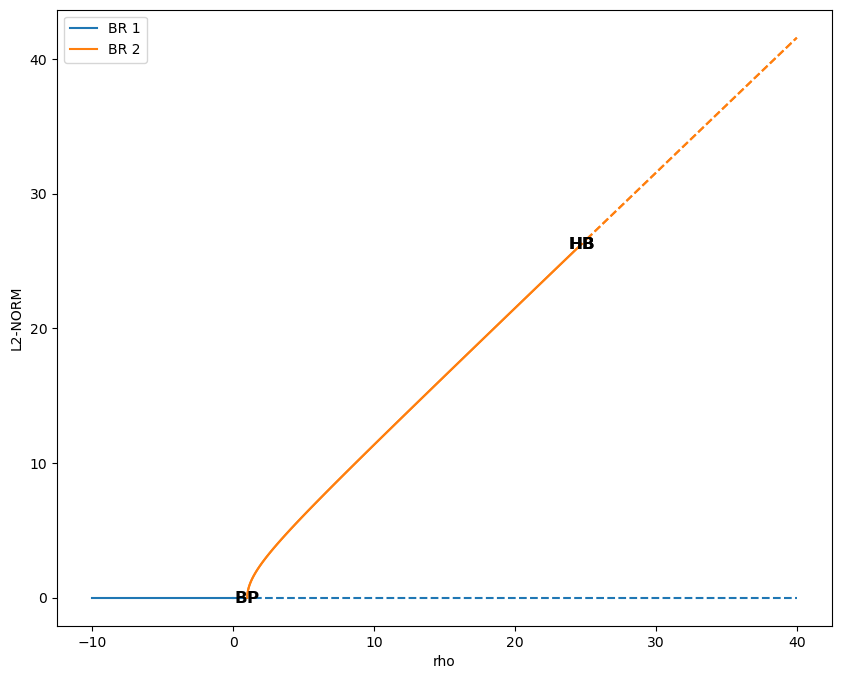

In [12]:
b.plot_fixed_points_diagram();

and also as functions of $x$ and $y$ :

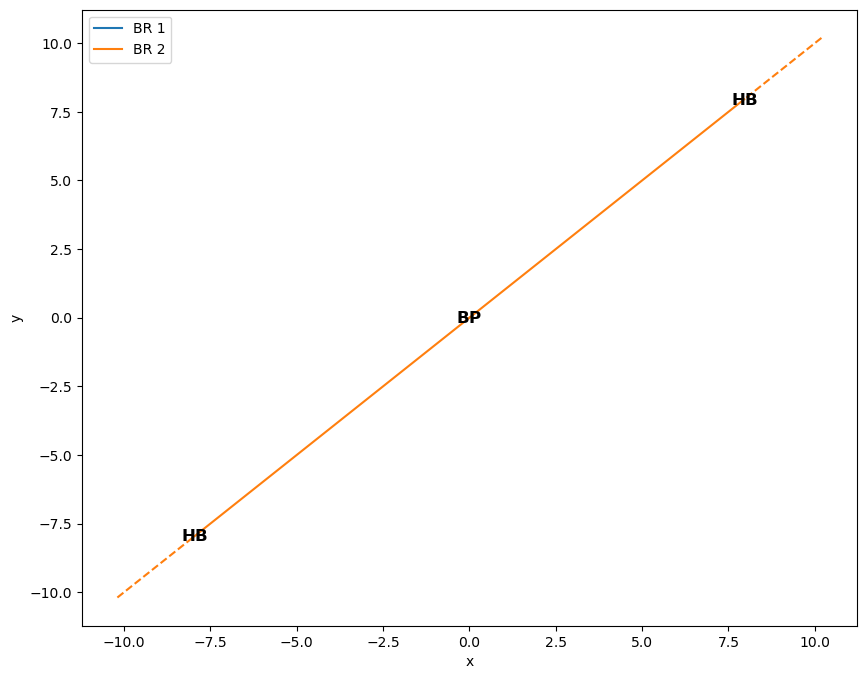

In [13]:
b.plot_fixed_points_diagram((2,3));

or in 3D as functions of $\rho$, $L^2$ norm and $x$ :

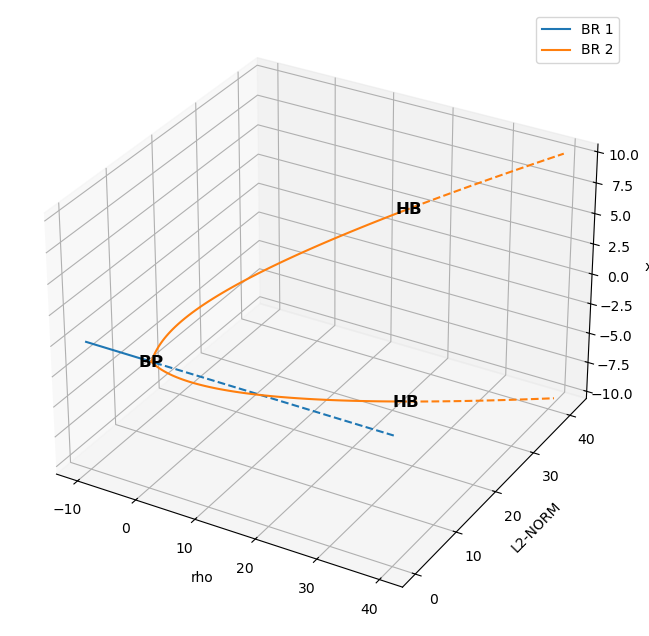

In [14]:
b.plot_fixed_points_diagram_3D();

We see that at 2 branches were found. The last one is symmetric and present distinct Hopf bifurcations.

We can continue periodic orbits out of these Hopf bifurcations : 

In [15]:
b.compute_periodic_orbits_diagram(
    3, 
    extra_comparison_parameters=['x', 'y'], 
    max_number_bp=None, 
    comparison_tol=[1.e-3, 1.e-3, 1.e-3],
    ICP=['rho']
)


2025-08-18 12:20:46,069 INFO: Model _lrz -- Module bifurcations.py -- Starting the computation of the periodic orbits bifurcation diagram with model lrz
2025-08-18 12:20:46,070 INFO: Model _lrz -- Module bifurcations.py -- Computing periodic orbits up to level 3
2025-08-18 12:20:46,070 INFO: Model _lrz -- Module bifurcations.py -- NMX parameters was not set, so setting it to 9000 points.
2025-08-18 12:20:46,071 INFO: Model _lrz -- Module bifurcations.py -- First, beginning computation of the periodic orbits from Hopf bifurcations.
2025-08-18 12:20:46,071 INFO: Model _lrz -- Module bifurcations.py -- Computing Hopf bifurcations of branch 1
2025-08-18 12:20:46,072 INFO: Model _lrz -- Module bifurcations.py -- Treating forward direction.
2025-08-18 12:20:46,072 INFO: Model _lrz -- Module bifurcations.py -- Treating backward direction.
2025-08-18 12:20:46,073 INFO: Model _lrz -- Module bifurcations.py -- Computing Hopf bifurcations of branch 2
2025-08-18 12:20:46,073 INFO: Model _lrz -- Mo

Runner configured
Starting lrz ...

  BR    PT  TY  LAB      rho         L2-NORM        MAX x         MAX y         MAX z           T       
   3    11  UZ   30   2.45000E+01   2.59656E+01   9.24769E+00   9.80466E+00   2.58419E+01   6.61109E-01
   3    26  UZ   31   2.20000E+01   2.27502E+01   1.15456E+01   1.33923E+01   2.79776E+01   7.64386E-01
   3    37  UZ   32   1.95000E+01   1.94750E+01   1.21107E+01   1.43924E+01   2.70241E+01   9.10724E-01
   3    48  UZ   33   1.70000E+01   1.60283E+01   1.20823E+01   1.44604E+01   2.50360E+01   1.14769E+00
   3    61  UZ   34   1.45000E+01   1.16544E+01   1.16340E+01   1.38730E+01   2.23621E+01   1.79457E+00
   3   109  MX   35   1.39265E+01   3.96043E-02   1.14795E+01   1.36564E+01   2.16709E+01   1.48075E+05

 Total Time    0.678E-01


2025-08-18 12:20:46,221 INFO: Model _lrz -- Module bifurcations.py -- Saving valid branch 3 emanating from branch 2 (Hopf point 1).
2025-08-18 12:20:46,222 INFO: Model _lrz -- Module bifurcations.py -- Treating backward direction.
2025-08-18 12:20:46,222 INFO: Model _lrz -- Module bifurcations.py -- Continuing PO out of Hopf point 1. Launching AUTO...


lrz ... done
Runner configured
Starting lrz ...

  BR    PT  TY  LAB      rho         L2-NORM        MAX x         MAX y         MAX z           T       
   4     3  BP   30   2.47364E+01   2.62680E+01  -7.89834E+00  -7.87606E+00   2.38381E+01   6.52845E-01
   4     9  UZ   31   2.45000E+01   2.59656E+01  -6.54471E+00  -6.06531E+00   2.58420E+01   6.61109E-01
   4    24  UZ   32   2.20000E+01   2.27502E+01  -3.03785E+00  -2.00925E+00   2.79780E+01   7.64386E-01
   4    35  UZ   33   1.95000E+01   1.94750E+01  -1.37628E+00  -4.82289E-01   2.70233E+01   9.10724E-01
   4    46  UZ   34   1.70000E+01   1.60283E+01  -4.26689E-01   1.96709E-01   2.50368E+01   1.14769E+00
   4    59  UZ   35   1.45000E+01   1.16544E+01  -1.75160E-02   3.46416E-01   2.23600E+01   1.79457E+00
   4   110  BP   36   1.39266E+01   5.79915E-02   3.65546E-07   3.24392E-01   2.16685E+01   1.54200E+05
   4   112  MX   37   1.39266E+01   3.97999E-01   6.33351E-06   3.16192E-01   2.16707E+01   1.46061E+05

 Total Time  

2025-08-18 12:20:46,384 INFO: Model _lrz -- Module bifurcations.py -- Saving valid branch 4 emanating from branch 2 (Hopf point 1).
2025-08-18 12:20:46,384 INFO: Model _lrz -- Module bifurcations.py -- Continuation of the periodic orbits from Hopf bifurcations has ended.
2025-08-18 12:20:46,385 INFO: Model _lrz -- Module bifurcations.py -- Beginning computation of the periodic orbits from detected branching and period doubling points.
2025-08-18 12:20:46,385 INFO: Model _lrz -- Module bifurcations.py -- Entering level 2 of continuation...
2025-08-18 12:20:46,386 INFO: Model _lrz -- Module bifurcations.py -- Continuing branching points of branch: 3
2025-08-18 12:20:46,386 INFO: Model _lrz -- Module bifurcations.py -- Treating forward direction.
2025-08-18 12:20:46,386 INFO: Model _lrz -- Module bifurcations.py -- Treating backward direction.
2025-08-18 12:20:46,387 INFO: Model _lrz -- Module bifurcations.py -- Computation of branching points of branch: 3 has ended.
2025-08-18 12:20:46,3

Runner configured
Starting lrz ...

  BR    PT  TY  LAB      rho         L2-NORM        MAX x         MAX y         MAX z           T       
   5     3  MX   38   2.46677E+01   2.61990E+01  -7.94442E+00  -7.94442E+00   2.36677E+01   6.53881E-01

 Total Time    0.108E-01
lrz ... done


2025-08-18 12:20:46,491 INFO: Model _lrz -- Module bifurcations.py -- Saving valid branch 5 emanating from branch 4 (branching point 1).
2025-08-18 12:20:46,492 INFO: Model _lrz -- Module bifurcations.py -- Continuing PO of branching point 2


Runner configured
Starting lrz ...

  BR    PT  TY  LAB      rho         L2-NORM        MAX x         MAX y         MAX z           T       
   6     4  MX   38   1.39266E+01   4.21422E-01   3.95170E-05   3.26447E-01   2.16676E+01   1.29787E+05

 Total Time    0.175E-01


2025-08-18 12:20:46,596 INFO: Model _lrz -- Module bifurcations.py -- Not saving results of PO point at ['rho', 'T'] = [13.92656682, 154200.36762] (branch 4) because it already exists (branch 5).
Skipping to next one.
2025-08-18 12:20:46,596 INFO: Model _lrz -- Module bifurcations.py -- Branching point 2 from branch 4 resulted in non-valid branch. Not saving result.
2025-08-18 12:20:46,597 INFO: Model _lrz -- Module bifurcations.py -- Treating backward direction.
2025-08-18 12:20:46,597 INFO: Model _lrz -- Module bifurcations.py -- Computation of branching points of branch: 4 has ended.
2025-08-18 12:20:46,598 INFO: Model _lrz -- Module bifurcations.py -- Continuing period doubling points of branch: 4
2025-08-18 12:20:46,598 INFO: Model _lrz -- Module bifurcations.py -- Treating forward direction.
2025-08-18 12:20:46,598 INFO: Model _lrz -- Module bifurcations.py -- Treating backward direction.
2025-08-18 12:20:46,599 INFO: Model _lrz -- Module bifurcations.py -- Computation of period 

lrz ... done


2025-08-18 12:20:46,604 INFO: Model _lrz -- Module bifurcations.py -- No more solutions to continue, finishing ...
2025-08-18 12:20:46,605 INFO: Model _lrz -- Module bifurcations.py -- Finished computation at level 2
2025-08-18 12:20:46,607 INFO: Model _lrz -- Module bifurcations.py -- All possible periodic orbit branches have been computed.


and plot the results on a bifurcation diagram:

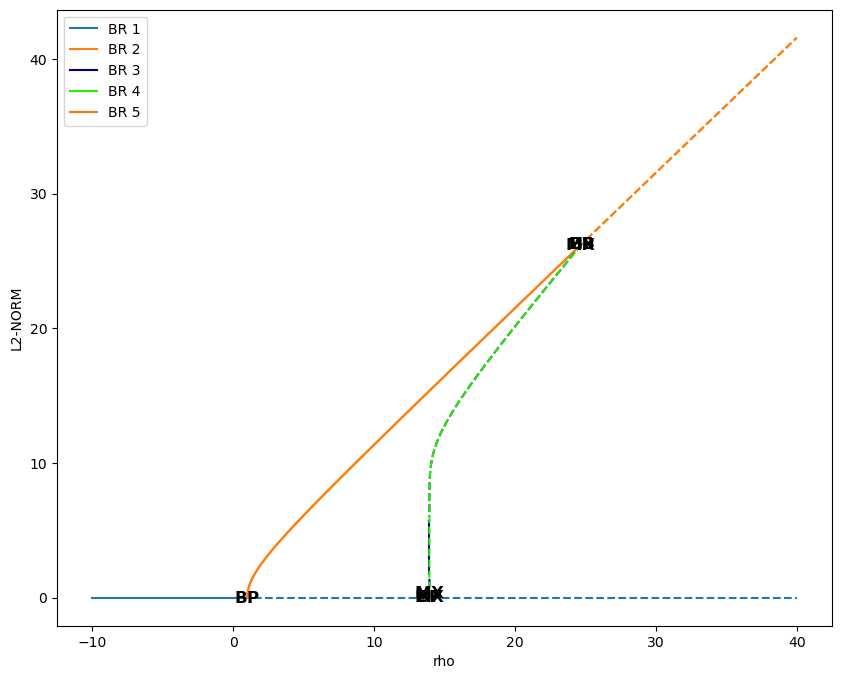

In [16]:
ax = b.plot_fixed_points_diagram()
b.plot_periodic_orbits_diagram(ax=ax, cmap='gist_ncar');

We can also plot both the bifurcation diagram and the solutions for a given value of $\rho$:

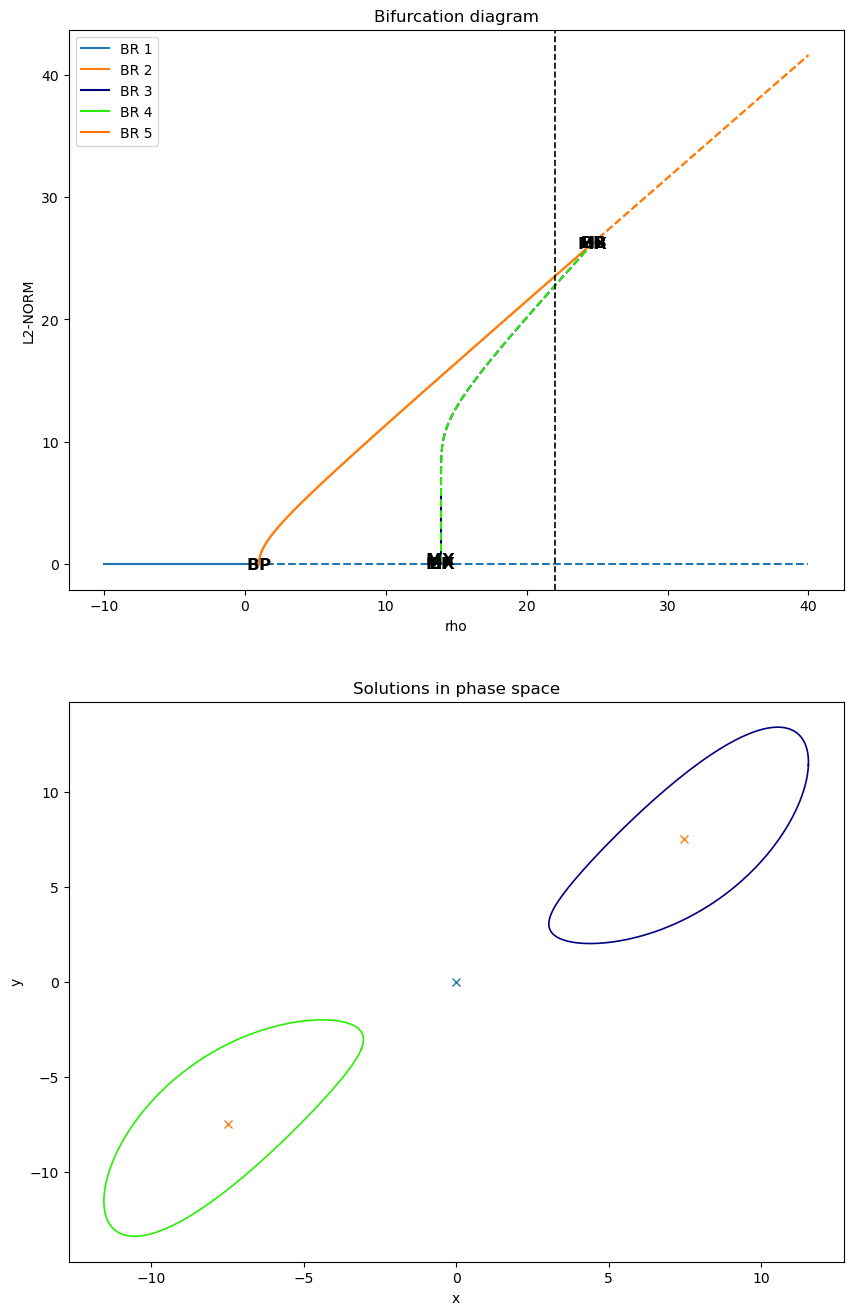

In [17]:
b.plot_diagram_and_solutions(22., solutions_variables=(0, 1), fixed_points_diagram_kwargs={'legend': True}, 
                             periodic_orbits_diagram_kwargs={'cmap': 'gist_ncar'});

or plot a single branch and its solutions:

array([<Axes: title={'center': 'Bifurcation diagram - Branch 4'}, xlabel='rho', ylabel='L2-NORM'>,
       <Axes: title={'center': 'Solutions in phase space'}, xlabel='x', ylabel='y'>],
      dtype=object)

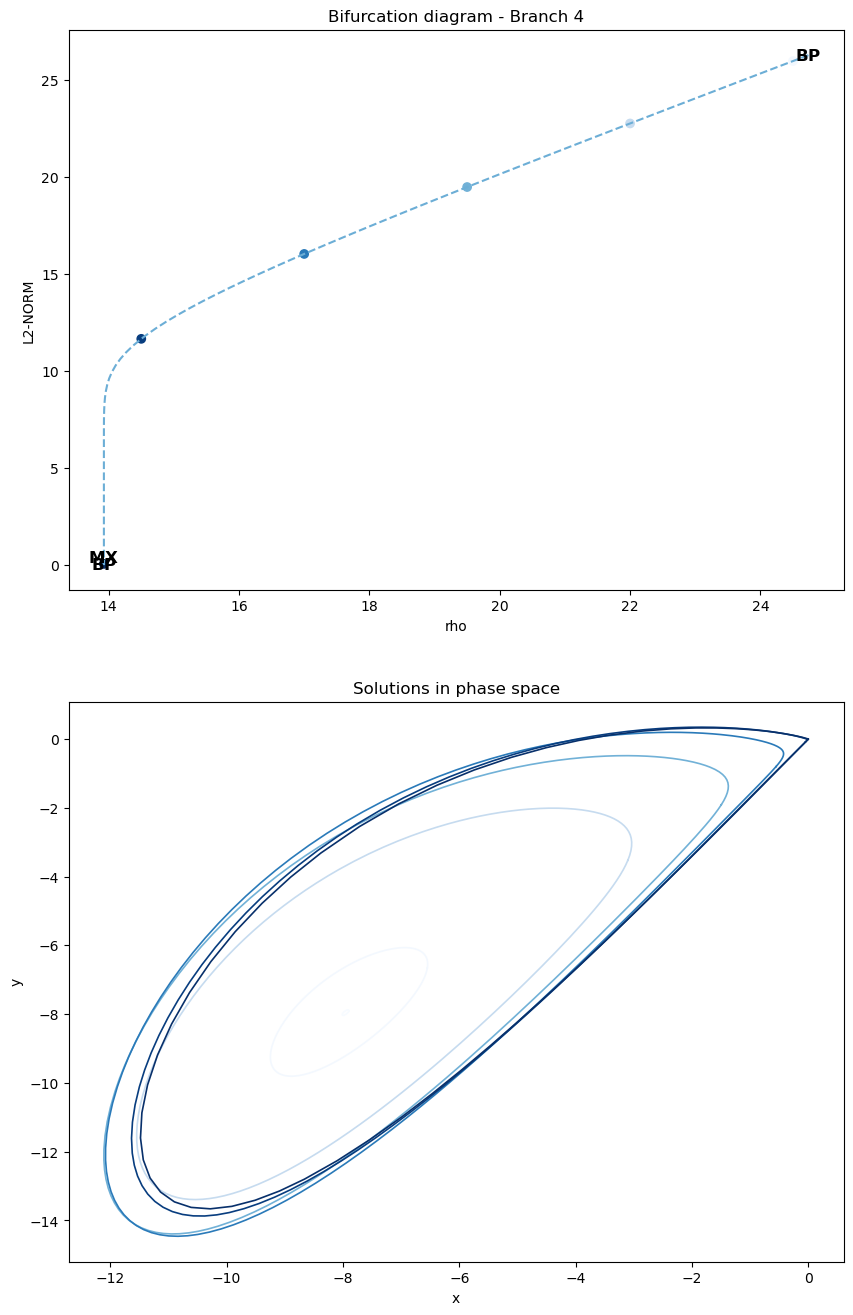

In [18]:
# plotting branch 4
b.plot_single_po_branch_and_solutions(4, cmap='Blues_r')

You can compare these results with the animated figure at the top of the notebook.
We can also plot the result in 3 dimensions to get a better view:

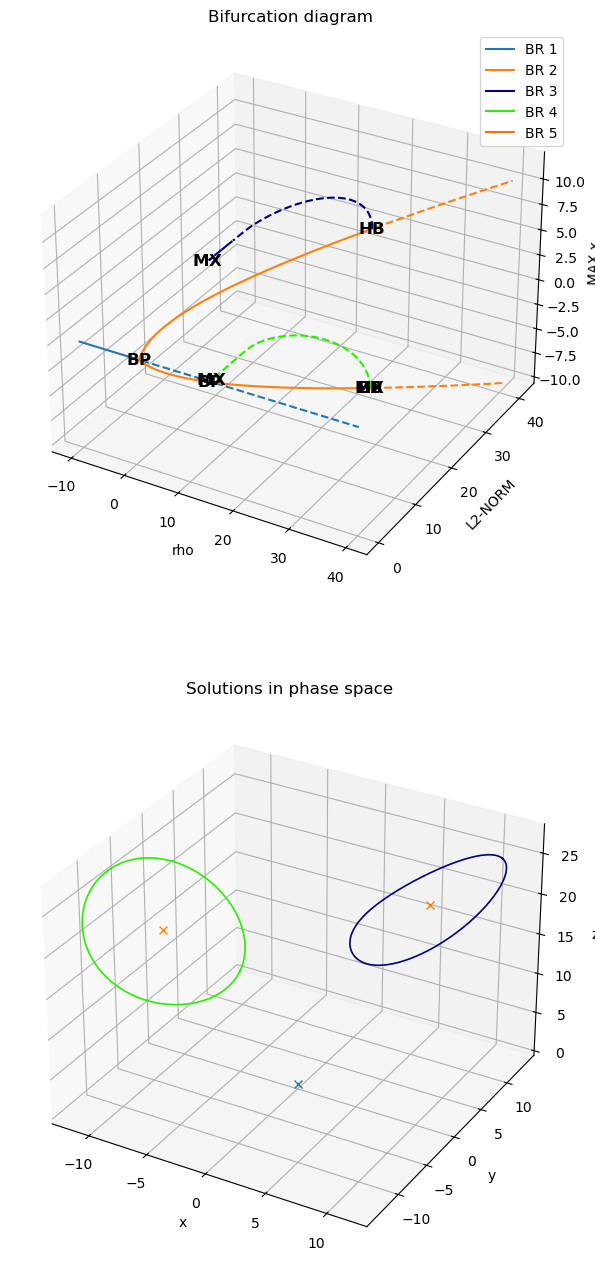

In [19]:
b.plot_diagram_in_3D_and_solutions_in_3D(22., solutions_variables=(0, 1, 2), fixed_points_diagram_kwargs={}, 
                                         periodic_orbits_diagram_kwargs={'cmap': 'gist_ncar'});

Finally, it is not hard to also plot the dynamics on the attractor (represented by the long trajectory computed beforehand) on top of the solutions to see their relevance:

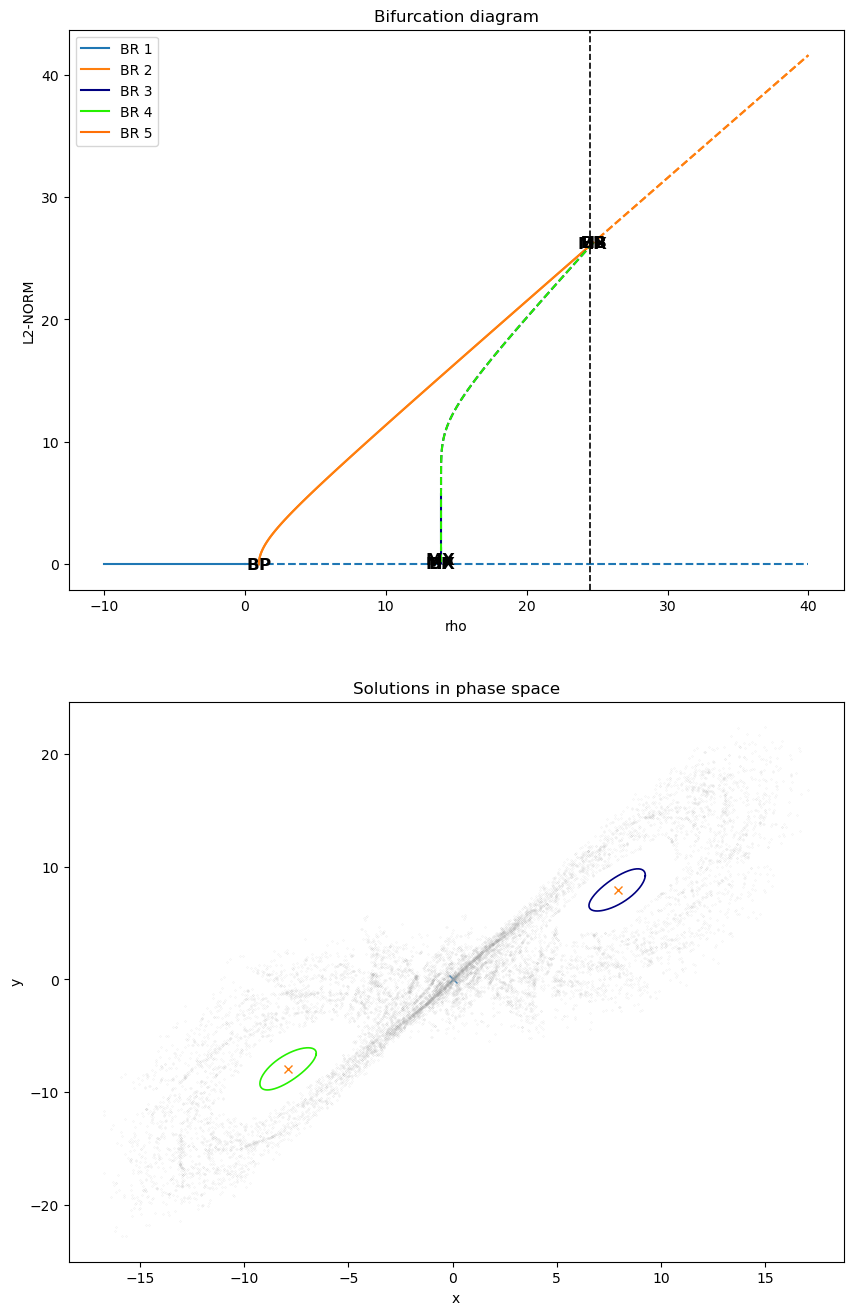

In [20]:
axs = b.plot_diagram_and_solutions(24.5, solutions_variables=(0, 1), fixed_points_diagram_kwargs={'legend': True}, 
                             periodic_orbits_diagram_kwargs={'cmap': 'gist_ncar'})
axs[1].plot(trajectory['y'][0], trajectory['y'][1], marker='o', ms=0.07, ls='', color='darkgray')

One can see that the chaotic dynamics is constrained by the two found periodic orbits. In fact, for $\rho=24.5$ (and values around), the basin of the Lorenz attractor is shielded away from the two stable symmetric equilibrium states by the 2D cylinder-shaped stable manifolds of the two “threshold” saddle orbits seen here. For more information, see Section 2.2 of Barrio et al. (2012) (see reference at the top of the notebook).

In [21]:
b.config_object.continuation_parameters

['rho']

In [22]:
b.fixed_points_solutions_list


[<_=AUTOSolution instance at 0x7ffb20082ed0>,
 <_=AUTOSolution instance at 0x7ffb200578c0>,
 <_=AUTOSolution instance at 0x7ffb20056db0>,
 <_=AUTOSolution instance at 0x7ffb20081460>,
 <_=AUTOSolution instance at 0x7ffb20081d90>,
 <_=AUTOSolution instance at 0x7ffb200810a0>,
 <_=AUTOSolution instance at 0x7ffb20082720>,
 <_=AUTOSolution instance at 0x7ffb20083fb0>,
 <_=AUTOSolution instance at 0x7ffb200811f0>,
 <_=AUTOSolution instance at 0x7ffb200801d0>,
 <_=AUTOSolution instance at 0x7ffb20080230>,
 <_=AUTOSolution instance at 0x7ffb20080830>,
 <_=AUTOSolution instance at 0x7ffb200805c0>,
 <_=AUTOSolution instance at 0x7ffb20080bc0>,
 <_=AUTOSolution instance at 0x7ffb20080a10>,
 <_=AUTOSolution instance at 0x7ffb20080260>,
 <_=AUTOSolution instance at 0x7ffb1feb7b60>,
 <_=AUTOSolution instance at 0x7ffb1feb7d70>,
 <_=AUTOSolution instance at 0x7ffb1feb7fe0>,
 <_=AUTOSolution instance at 0x7ffb200967b0>,
 <_=AUTOSolution instance at 0x7ffb20096450>,
 <_=AUTOSolution instance at 0x7ff

In [23]:
b.__weakref__

